In [2]:
!pip install efficientnet_pytorch


  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [8]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from tqdm import tqdm
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from albumentations import Compose, HorizontalFlip, Rotate, Resize
from albumentations.pytorch import ToTensorV2
from efficientnet_pytorch import EfficientNet
import torch.nn.functional as F


In [9]:
class LungDataset(Dataset):
    def __init__(self, data_paths):
        self.data_paths = data_paths
        self.label2id = {label: id for id, label in enumerate([
            "Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis", "Viral Pneumonia"
        ])}

    def __getitem__(self, index):
        image_path = self.data_paths[index]
        label = Path(image_path).parent.name
        transform = Compose([
            HorizontalFlip(p=0.5),
            Rotate(limit=10, p=0.25),
            Resize(256, 256),
            ToTensorV2()
        ])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = transform(image=image)["image"]
        label_id = self.label2id[label]
        return image.float(), torch.tensor(label_id, dtype=torch.long)

    def __len__(self):
        return len(self.data_paths)

In [10]:
class LungClassificationModel(torch.nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        self.fc = torch.nn.Linear(self.backbone._fc.in_features, num_classes)

    def forward(self, x):
        x = self.backbone.extract_features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        return self.fc(x)

In [11]:
data_path = '/content/drive/MyDrive/CVProject/data/lung_disease_dataset'
train_data_path = glob(f"{data_path}/train/**/*.jpeg", recursive=True)
val_data_path = glob(f"{data_path}/val/**/*.jpeg", recursive=True)
test_data_path = glob(f"{data_path}/test/**/*.jpeg", recursive=True)

train_ds = LungDataset(train_data_path)
val_ds = LungDataset(val_data_path)
test_ds = LungDataset(test_data_path)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4)
test_dl = DataLoader(test_ds, batch_size=4)

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LungClassificationModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003)
criterion = torch.nn.CrossEntropyLoss()

Loaded pretrained weights for efficientnet-b0


In [12]:
# Training, validation, and plotting
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0, 0
    for images, labels in tqdm(train_dl, desc=f"Epoch {epoch+1} Training"):
        images, labels = images.to(device).float(), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    epoch_train_loss = train_loss / len(train_dl)
    epoch_train_accuracy = train_correct / len(train_dl.dataset)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_dl, desc=f"Epoch {epoch+1} Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    epoch_val_loss = val_loss / len(val_dl)
    epoch_val_accuracy = val_correct / len(val_dl.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")

# Final test and plot code remains the same
def test_model(test_dl, model):
    model.eval()
    test_loss, test_correct = 0, 0
    test_labels, test_preds = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_dl, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = outputs.argmax(1)
            test_correct += (preds == labels).type(torch.float).sum().item()
            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(preds.cpu().numpy())

    test_accuracy = test_correct / len(test_dl.dataset)
    test_f1_score = f1_score(test_labels, test_preds, average='weighted')
    return test_loss / len(test_dl), test_accuracy, test_f1_score

# Evaluate the model on the test dataset
test_loss, test_accuracy, test_f1_score = test_model(test_dl, model)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1_score:.4f}")

# Plot training and validation loss and accurac

Epoch 1 Validation: 100%|██████████| 397/397 [11:11<00:00,  1.69s/it]


Epoch 1/10 - Training Loss: 0.5910, Training Accuracy: 0.7716, Validation Loss: 0.4026, Validation Accuracy: 0.8418


Epoch 2 Validation: 100%|██████████| 397/397 [00:47<00:00,  8.30it/s]


Epoch 2/10 - Training Loss: 0.4094, Training Accuracy: 0.8377, Validation Loss: 0.3574, Validation Accuracy: 0.8645


Epoch 3 Validation: 100%|██████████| 397/397 [00:46<00:00,  8.55it/s]


Epoch 3/10 - Training Loss: 0.3406, Training Accuracy: 0.8636, Validation Loss: 0.3496, Validation Accuracy: 0.8595


Epoch 4 Validation: 100%|██████████| 397/397 [00:45<00:00,  8.80it/s]


Epoch 4/10 - Training Loss: 0.3122, Training Accuracy: 0.8711, Validation Loss: 0.3460, Validation Accuracy: 0.8551


Epoch 5 Validation: 100%|██████████| 397/397 [00:45<00:00,  8.64it/s]


Epoch 5/10 - Training Loss: 0.2886, Training Accuracy: 0.8819, Validation Loss: 0.2940, Validation Accuracy: 0.8771


Epoch 6 Validation: 100%|██████████| 397/397 [00:47<00:00,  8.42it/s]


Epoch 6/10 - Training Loss: 0.2525, Training Accuracy: 0.9008, Validation Loss: 0.3159, Validation Accuracy: 0.8633


Epoch 7 Validation: 100%|██████████| 397/397 [00:44<00:00,  8.98it/s]


Epoch 7/10 - Training Loss: 0.2422, Training Accuracy: 0.9074, Validation Loss: 0.4378, Validation Accuracy: 0.8267


Epoch 8 Validation: 100%|██████████| 397/397 [00:45<00:00,  8.77it/s]


Epoch 8/10 - Training Loss: 0.2042, Training Accuracy: 0.9236, Validation Loss: 0.3124, Validation Accuracy: 0.8822


Epoch 9 Validation: 100%|██████████| 397/397 [00:44<00:00,  8.98it/s]


Epoch 9/10 - Training Loss: 0.1876, Training Accuracy: 0.9294, Validation Loss: 0.3558, Validation Accuracy: 0.8721


Epoch 10 Validation: 100%|██████████| 397/397 [00:45<00:00,  8.71it/s]


Epoch 10/10 - Training Loss: 0.1835, Training Accuracy: 0.9311, Validation Loss: 0.3865, Validation Accuracy: 0.8740


Testing: 100%|██████████| 398/398 [11:09<00:00,  1.68s/it]

Test Loss: 0.4060, Test Accuracy: 0.8579, Test F1 Score: 0.8558


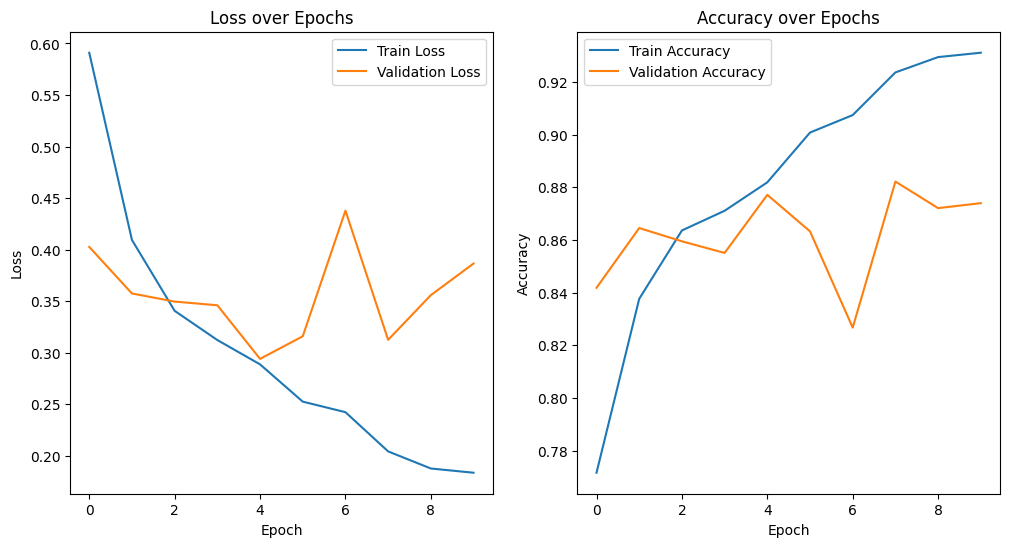

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Testing: 100%|██████████| 398/398 [00:44<00:00,  8.97it/s]


Test Loss: 0.4111, Test Accuracy: 0.8629, Test F1 Score: 0.8611


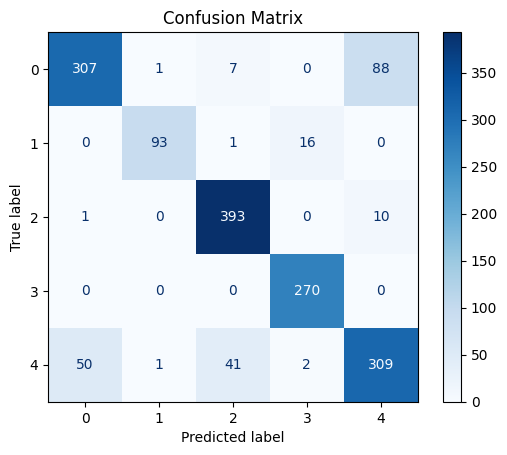

In [16]:
# Test the model and return labels and predictions for confusion matrix
def test_model(test_dl, model):
    model.eval()
    test_loss, test_correct = 0, 0
    test_labels, test_preds = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_dl, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = outputs.argmax(1)
            test_correct += (preds == labels).type(torch.float).sum().item()
            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(preds.cpu().numpy())

    test_accuracy = test_correct / len(test_dl.dataset)
    test_f1_score = f1_score(test_labels, test_preds, average='weighted')
    return test_loss / len(test_dl), test_accuracy, test_f1_score, test_labels, test_preds

# Evaluate the model on the test dataset
test_loss, test_accuracy, test_f1_score, test_labels, test_preds = test_model(test_dl, model)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1_score:.4f}")

# Now display the confusion matrix
def display_confusion_matrix(test_labels, test_preds):
    cm = confusion_matrix(test_labels, test_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Call the function to display the confusion matrix
display_confusion_matrix(test_labels, test_preds)
